In [ ]:
import pandas as pd
import numpy as np
from gensim.models import FastText

In [ ]:
training = pd.read_json("https://raw.githubusercontent.com/emorynlp/character-identification/master/json/character-identification-trn.json")

In [ ]:
#%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
utterance = 0
scene =0
episode = 0


X = []
y = []
Sentences = []
for episode in range(len(training.values)):
  E = training.values[episode][1]
  for scene in E['scenes']:
    for utterance in scene['utterances']:  
      X.append(' '.join([item for sl in utterance['tokens'] for item in sl]))
      y.append(utterance['speakers'][0])
      Sentences.append([item for item in utterance['tokens']])
      # print( utterance['tokens'])

In [ ]:
Text = []
for u in Sentences:
  for w in u:
    Text.append(w)


In [ ]:
df = pd.DataFrame({'Utterance' : X, 'Name' : y})
df.loc[:, 'Labels'] = "Other"
df.loc[df['Name'] == 'Joey Tribbiani', 'Labels'] = "Joey"
df.loc[df['Name'] == 'Chandler Bing', 'Labels'] = "Chandler"
df.loc[df['Name'] == 'Ross Geller', 'Labels'] = "Ross"
df.loc[df['Name'] == 'Phoebe Buffay', 'Labels'] = "Phoebe"
df.loc[df['Name'] == 'Rachel Green', 'Labels'] = "Rachel"
df.loc[df['Name'] == 'Monica Geller', 'Labels'] = "Monica"

In [ ]:
import gensim.downloader as api

corpus = api.load('text8')

[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
import string

for i in range(len(df.Utterance)):
  df['Utterance'][i].translate(str.maketrans('', '', string.punctuation))
embedding_dim=100

In [ ]:
from gensim.models.word2vec import Word2Vec
 
Dialogues_by_Speaker = df.groupby("Name")["Utterance"].count().nlargest(6)
# print(Dialogues_by_Speaker)
print(df.head(10))
 
model = Word2Vec(corpus)
# model = FastText(Text, size=embedding_dim, window=5, min_count=1, workers=4, sg=0)
#model = FastText.load_fasttext_format(Sentences)
print(len(model.wv.vocab.keys()))
print(model.wv.vector_size)
# #print(model.wv.get_vector('assalu'))
# print(model.wv.most_similar('assalu'))
model.wv.save_word2vec_format('FastTextVectorsFinal.txt', fvocab = 'Vocab')

                                           Utterance            Name    Labels
0  There 's nothing to tell ! He 's just some guy...   Monica Geller    Monica
1  C'mon , you 're going out with the guy ! There...  Joey Tribbiani      Joey
2  All right Joey , be nice . So does he have a h...   Chandler Bing  Chandler
3                         Wait , does he eat chalk ?   Phoebe Buffay    Phoebe
4  Just , ' cause , I do n't want her to go throu...   Phoebe Buffay    Phoebe
5  Okay , everybody relax . This is not even a da...   Monica Geller    Monica
6                         Sounds like a date to me .   Chandler Bing  Chandler
7  Alright , so I 'm back in high school , I 'm s...   Chandler Bing  Chandler
8                       Oh , yeah . Had that dream .           #ALL#     Other
9  Then I look down , and I realize there 's a ph...   Chandler Bing  Chandler
71290
100


In [ ]:
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
 
labels = df['Labels'].values
sentences = df['Utterance'].values
 
#categorical_labels = to_categorical(labels, num_classes=7)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.25, random_state=1000)
 
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=6000, lower=True)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

print(sentences_train[2])
print(X_train[2])

Hey there .
[35, 48]


In [ ]:
from keras.preprocessing.sequence import pad_sequences

def pad_repeat(A, size=100):
  return np.vstack([np.resize(A[i], size) for i in range(len(A))])

maxlen = 100

X_train=pad_repeat(X_train,maxlen)
X_test=pad_repeat(X_test,maxlen)


In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix


#uploaded=files.upload()
embedding_matrix = create_embedding_matrix('FastTextVectorsFinal.txt', tokenizer.word_index, embedding_dim)

In [ ]:
import tensorflow.keras as keras
import sys

class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_test_batch_end(self, batch, logs=None):
        sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
      if epoch % 10 == 0:
        print("Epoch finished {:d}.".format(epoch), logs)

In [ ]:
import numpy as np


class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [ ]:
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate, Average   
from keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D, Conv2D,MaxPooling2D, MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten
from tensorflow.keras import regularizers
import sys

input_shape = (maxlen,)
model_input = Input(shape=input_shape)
EmbedLayer = Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False)(model_input)
EmbedLayer = Dropout(0.5)(EmbedLayer)

Filter1 = Conv1D(100, kernel_size=(3),kernel_regularizer=regularizers.l2(0.00001), padding='same')(EmbedLayer)
Filter1 = LeakyReLU(alpha=0.2)(Filter1)
Filter1 = MaxPooling1D(pool_size=2)(Filter1)
#model1.add(SpatialDropout1D(0.5))
Filter1 = Flatten()(Filter1)


Filter2 = Conv1D(100, kernel_size=(8),kernel_regularizer=regularizers.l2(0.00001), padding='same')(EmbedLayer)
Filter2 = LeakyReLU(alpha=0.2)(Filter2)
Filter2 = MaxPooling1D(pool_size=2)(Filter2)
#model2.add(SpatialDropout1D(0.5))
Filter2 = Flatten()(Filter2)

merged = Concatenate()([Filter1, Filter2])

merged = Dropout(0.8)(merged)
#model = Concatenate()([model1, model2])
#model.add(Bidirectional(LSTM(50,dropout=0.5, recurrent_dropout=0.5)))
#merged = Dense(10, activation='relu')(merged)
model_output = Dense(7,activation='softmax')(merged)

model = Model(model_input, model_output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
print(y_train.shape, y_test.shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     764200      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 100)     30100       dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
import matplotlib.pyplot as plt
import argparse

history = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=False,
                    validation_split=0.1,
                    batch_size=128,
                    callbacks=[LossAndErrorPrintingCallback()])


In [ ]:
# testing = pd.read_json("https://raw.githubusercontent.com/emorynlp/character-identification/master/json/character-identification-tst.json")
# X_test = []
# y_test = []

# # for episode in range(len(testing.values)):
#   E = training.values[episode][1]
#   for scene in E['scenes']:
#     for utterance in scene['utterances']:  
#       X_test.append([item for sl in utterance['tokens'] for item in sl])
#       y_test.append(utterance['speakers'][0])

[INFO] evaluating network...
[6 6 6 ... 0 2 6]
DescribeResult(nobs=4698, minmax=(0, 6), mean=5.168582375478927, variance=3.5879247942560553, skewness=-2.0108735630915064, kurtosis=2.340408425693629)
[0 4 5 ... 1 6 4]
              precision    recall  f1-score   support

           0       0.18      0.10      0.13       672
           1       0.20      0.05      0.08       561
           2       0.14      0.03      0.05       653
           3       0.30      0.03      0.06       902
           4       0.23      0.03      0.05       532
           5       0.16      0.01      0.01       639
           6       0.16      0.85      0.27       739

    accuracy                           0.17      4698
   macro avg       0.20      0.16      0.09      4698
weighted avg       0.20      0.17      0.10      4698

[INFO] serializing network and label binarizer...


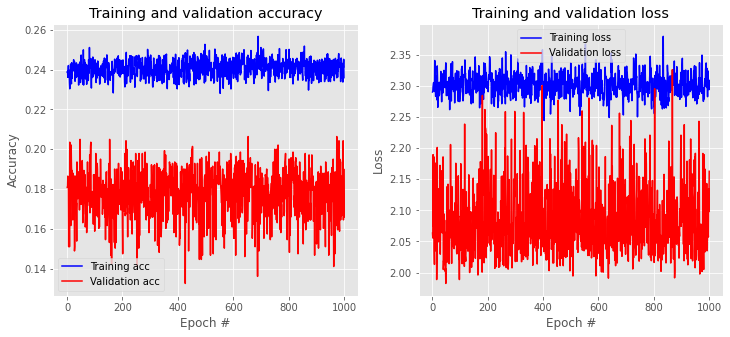

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt 
from google.colab import files
import io
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predictions = model.predict(x=X_test, batch_size=16)
print(predictions.argmax(axis=1))
print(stats.describe(predictions.argmax(axis=1)))
print(y_test.argmax(axis=1))
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

plt.style.use('ggplot')

def plot_history(history):
    #N = np.arrange(0, 50) #no of Epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    #plt.savefig(args["plot"])

plot_history(history)

print("[INFO] serializing network and label binarizer...")
#model.save(args["model"], save_format="h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate, Average   
from keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D, Conv2D,MaxPooling2D, MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten
from tensorflow.keras import regularizers
import sys
from keras import backend as K
from keras.layers.core import Lambda

def element_max(X):
  return K.max(X, axis=2, keepdims=True)

input_shape = (maxlen,)
model_input = Input(shape=input_shape)
EmbedLayer = Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False)(model_input)
EmbedLayer = Dropout(0.5)(EmbedLayer)

Filter1 = Conv1D(500, kernel_size=(3),kernel_regularizer=regularizers.l2(0.00001), padding='same')(EmbedLayer)
Filter1 = LeakyReLU(alpha=0.2)(Filter1)
model_output = Lambda(element_max)(Filter1)
#model1.add(SpatialDropout1D(0.5))
# Filter1 = Flatten()(Filter1)


# Filter2 = Conv1D(100, kernel_size=(10),kernel_regularizer=regularizers.l2(0.00001), padding='same')(EmbedLayer)
# Filter2 = LeakyReLU(alpha=0.2)(Filter2)
# Filter2 = MaxPooling1D(pool_size=2)(Filter2)
# #model2.add(SpatialDropout1D(0.5))
# Filter2 = Flatten()(Filter2)

# merged = Concatenate()([Filter1, Filter2])

# merged = Dropout(0.8)(merged)
#model = Concatenate()([model1, model2])
#model.add(Bidirectional(LSTM(50,dropout=0.5, recurrent_dropout=0.5)))
# merged = Dense(10, activation='relu')(merged)
# model_output = Dense(6,activation='softmax')(merged)

model = Model(model_input, model_output)
model.compile()
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          764200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 500)          150500    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100, 500)          0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 1)            0         
Total params: 914,700
Trainable params: 150,500
Non-trainable params: 764,200
_______________________________________________

In [ ]:
history=model.fit(x = X_train, y = X_train, epochs=5)

Epoch 1/5
441/441 [==============================] - 1s 1ms/step - loss: 2.1484e-04
Epoch 2/5
441/441 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 3/5
441/441 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 4/5
441/441 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 5/5
441/441 [==============================] - 1s 2ms/step - loss: 0.0000e+00


In [ ]:
def prepare_input(D):
  before1 = np.roll(D, shift=-1, axis=0).reshape(-1,1,maxlen,1)
  before2 =  np.roll(D, shift=-2).reshape(-1,1,maxlen,1)
  return np.hstack((before2, before1, D.reshape(-1,1,maxlen,1)))

# X_train_new = prepare_input(model.predict(X_train))
# X_test_new = prepare_input(model.predict(X_test))
X_train_new = prepare_input(X_train)
X_test_new = prepare_input(X_test)

(14091, 3, 100, 1)

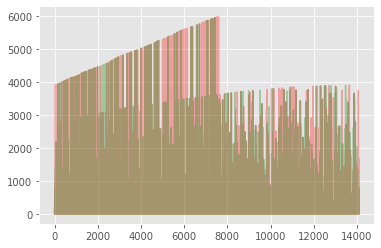

In [ ]:
plt.plot(X_train_new[:,0, 0], alpha=0.3, color='r')
plt.plot(X_train[:, 0], alpha=0.3, color='g')
X_train_new.shape

In [ ]:
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate, Average   
from keras import layers
from tensorflow.keras.layers import Reshape,Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D, Conv2D,MaxPooling2D, MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten, TimeDistributed
from tensorflow.keras import regularizers
import sys

#option 1
# inputA = Input(shape=(maxlen,1))
# inputB = Input(shape=(maxlen,1))
# inputC = Input(shape=(maxlen,1))
# inputs = [inputA, inputB, inputC]
# com=concatenate(inputs)
# FF1=Dense(1, activation='tanh')(com)
# FF2=Flatten()(FF1)
# output=Dense(units=7, activation='softmax')(FF2)
# model = Model(inputs=inputs, outputs=output)


# option 2
inputs = Input(shape=X_train_new.shape[1:])
FF1=Dense(units=1, activation='tanh')
TD=TimeDistributed(FF1)(inputs)
FF2=Flatten()(TD)
output=Dense(units=7, activation='softmax')(FF2)

model = Model(inputs, output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 3, 100, 1)]       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 100, 1)         2         
_________________________________________________________________
flatten_7 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 2107      
Total params: 2,109
Trainable params: 2,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
import argparse

# Data = [X_train_new[:,0], X_train_new[:,1], X_train_new[:,2]]
Data = X_train_new

history = model.fit(Data, y_train,
                    epochs=200,
                    verbose=False,
                    validation_split=0.1,
                    batch_size=128,
                    callbacks=[LossAndErrorPrintingCallback()]) #EarlyStoppingAtMinLoss(15)])


For batch 11, loss is    1.99.Epoch finished 0. {'loss': 1.9439040422439575, 'accuracy': 0.17403990030288696, 'val_loss': 1.9878935813903809, 'val_accuracy': 0.1460992842912674}
For batch 11, loss is    1.96.Epoch finished 10. {'loss': 1.9339232444763184, 'accuracy': 0.17892910540103912, 'val_loss': 1.9624731540679932, 'val_accuracy': 0.16879431903362274}
For batch 11, loss is    1.97.Epoch finished 20. {'loss': 1.9330114126205444, 'accuracy': 0.1836605966091156, 'val_loss': 1.9742752313613892, 'val_accuracy': 0.15886524319648743}
For batch 11, loss is    1.98.Epoch finished 30. {'loss': 1.9313762187957764, 'accuracy': 0.18547433614730835, 'val_loss': 1.9809255599975586, 'val_accuracy': 0.16099290549755096}
For batch 11, loss is    1.98.Epoch finished 40. {'loss': 1.9223788976669312, 'accuracy': 0.1932024359703064, 'val_loss': 1.9803290367126465, 'val_accuracy': 0.16099290549755096}
For batch 11, loss is    1.98.Epoch finished 50. {'loss': 1.9219821691513062, 'accuracy': 0.192019551992

In [ ]:
[X_train_new[:,0], X_train_new[:,1], X_train_new[:,2]]

[INFO] evaluating network...
[5 3 3 ... 3 3 2]
DescribeResult(nobs=4698, minmax=(0, 6), mean=3.3331204767986375, variance=2.3780426769874667, skewness=-0.31790418469932746, kurtosis=0.2424641360095765)
[0 4 5 ... 1 6 4]
[INFO] serializing network and label binarizer...


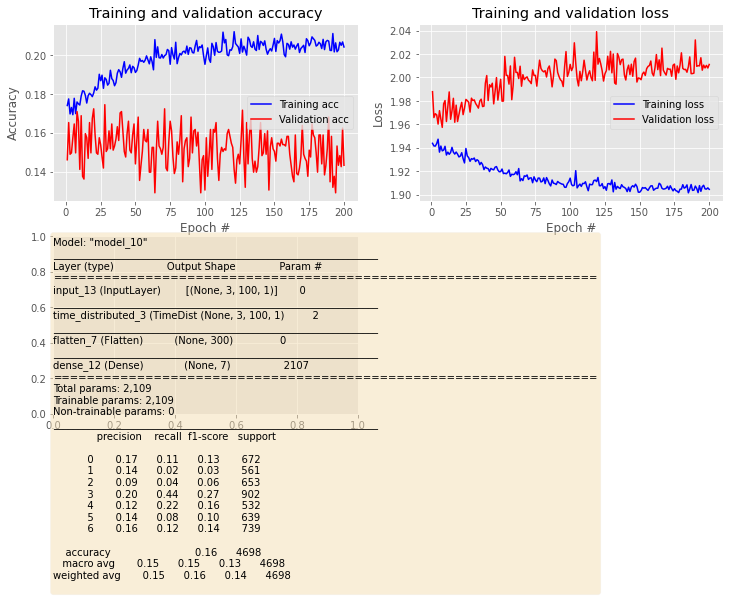

In [ ]:
from scipy import stats
from datetime import datetime
from sklearn.metrics import classification_report

# TEST= [X_test_new[:,0], X_test_new[:,1], X_test_new[:,2]]
TEST=X_test_new

print("[INFO] evaluating network...")
predictions = model.predict(x=TEST, batch_size=16)
print(predictions.argmax(axis=1))
print(stats.describe(predictions.argmax(axis=1)))
print(y_test.argmax(axis=1))
class_report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
# print(class_report)

plt.style.use('ggplot')

def plot_history(history):
    #N = np.arrange(0, 50) #no of Epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 15))
    plt.subplot(4, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(4, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    ax = plt.subplot(4, 2, 3)
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    short_model_summary += '\n' + class_report
# place a text box in upper left in axes coords
    ax.text(0.00, 1.0, short_model_summary , fontsize=10, verticalalignment='top', bbox=props)
    fname = f'/content/drive/MyDrive/DataScience/Results/{datetime.now().timestamp()}'
    plt.savefig(fname[:-7])

plot_history(history)

print("[INFO] serializing network and label binarizer...")
#model.save(args["model"], save_format="h5")